The first thing we need to do is import the necessary libraries.

In [1]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Then we load the data and do some basic exploration 

Train Shape: (595212, 59)
Test Shape: (892816, 58)
Train Data:
    id  target  ps_ind_01  ps_ind_02_cat  ps_ind_03  ps_ind_04_cat  \
0   7       0          2              2          5              1   
1   9       0          1              1          7              0   
2  13       0          5              4          9              1   
3  16       0          0              1          2              0   
4  17       0          0              2          0              1   

   ps_ind_05_cat  ps_ind_06_bin  ps_ind_07_bin  ps_ind_08_bin  ...  \
0              0              0              1              0  ...   
1              0              0              0              1  ...   
2              0              0              0              1  ...   
3              0              1              0              0  ...   
4              0              1              0              0  ...   

   ps_calc_11  ps_calc_12  ps_calc_13  ps_calc_14  ps_calc_15_bin  \
0           9           1      

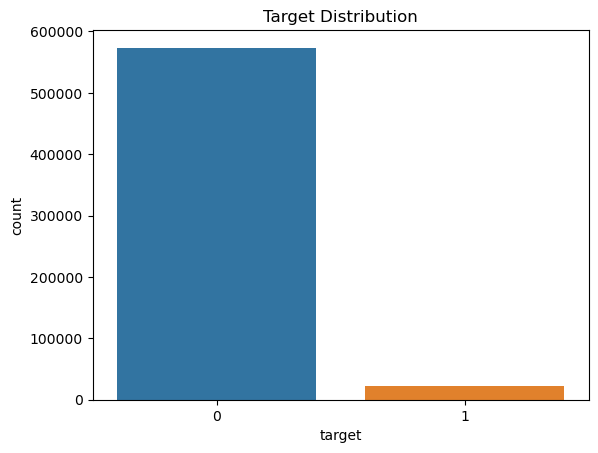

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Check data structure
print("Train Shape:", train.shape)
print("Test Shape:", test.shape)

#look at the first couple lines of data in the structures
print("Train Data:\n", train.head())
print("Test Data:\n", test.head())

#Description of test and train data
print("Train Data Description:\n", train.describe())
print("Test Data Description:\n", test.describe())

# Count missing values (-1) in each column
missing_values = (train == -1).sum()

print("\nMissing Values in Train Data:")
print(missing_values[missing_values > 0].sort_values(ascending=False))

# Check target distribution (imbalance)
sns.countplot(x=train["target"])
plt.title("Target Distribution")
plt.show()

This data is a little hard to do in depth analysis on becuase the data provider has already normalized and changed a bunch of the values for us. This means that all the data is already represented as a number so we don't have to deal with strings or categorical data. Although from the kaggle description we do know some of what the data represents. For example the data that ends in cat is categorical data, bin represents binary data, and features without without either of those are either continuous or ordinal.

We also can see that the data very heavily favors 0 in the target meaning that our models will probably want to favor 0 as the prediction unless we make an effort to change that.

In [3]:
#Preprocess the data
# Assuming the target column is named 'target' and features are in other columns
X_train = train.drop(columns=['target']).values
y_train = train['target'].values

X_test = test.drop(columns=['target']).values if 'target' in test else test.values
y_test = test['target'].values if 'target' in test else None

# Normalize features
X_train = (X_train - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)
if X_test is not None:
    X_test = (X_test - np.mean(X_test, axis=0)) / np.std(X_test, axis=0)


We did the following to remove any missing data to give us a full data set to use. We replaced missing values with the median values for the feature. We also did some basic feature processing on the data.

Here are the functions for a basic regression model we are going to run on the data

In [4]:
#Logistic Regression model(without regularization)
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_cost(X, y, weights):
    m = len(y)
    predictions = sigmoid(np.dot(X, weights))
    cost = -(1/m) * np.sum(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))
    return cost

def gradient_descent(X, y, weights, learning_rate, iterations):
    m = len(y)
    for i in range(iterations):
        predictions = sigmoid(np.dot(X, weights))
        gradient = np.dot(X.T, (predictions - y)) / m
        weights -= learning_rate * gradient
        if i % 100 == 0:
            print(f"Iteration {i}: Cost {compute_cost(X, y, weights)}")
    return weights


Now we train the basic regression model

In [5]:
# Add a bias term to the features
X_train = np.c_[np.ones((X_train.shape[0], 1)), X_train]
weights = np.zeros(X_train.shape[1])

# Hyperparameters Got 0.24293
learning_rate = 0.01
iterations = 1000

# # Train the model
# weights = gradient_descent(X_train, y_train, weights, learning_rate, iterations)

Now , let's evaluate the model on the test set and create a submission for it:

In [6]:
learning_rates = [0.001, 0.01, 0.1, 0.2]
iterations_list = [500, 1000, 2000, 5000]

learning_rates = [0.0005, 0.001, 0.005, 0.01]
iterations_list = [1000, 1500, 2000, 3000]


for lr in learning_rates:
    for iters in iterations_list:
        print(f"Training with learning rate {lr} and {iters} iterations.")
        weights = np.zeros(X_train.shape[1])
        weights = gradient_descent(X_train, y_train, weights, lr, iters)

        if y_test is None:  # Assuming test data does not have target labels
            # Ensure the test dataset has an ID column
            if 'id' in test.columns:
                ids = test['id'].values
            else:
                raise ValueError("The test dataset must contain an 'ID' column for submission.")

            # Add a bias term to the test features
            X_testTemp = np.c_[np.ones((X_test.shape[0], 1)), X_test]

            # Calculate probabilities using the sigmoid function
            probabilities = sigmoid(np.dot(X_testTemp, weights))

            # Create a DataFrame for submission
            submission = pd.DataFrame({
                'id': ids,
                'target': probabilities
            })

            # Adjust the filename to include the learning rate and iterations
            filename = f"submission_lr{lr}_iters{iters}.csv"
            
            # Save the submission file
            submission.to_csv(filename, index=False)
            print(f"Submission file '{filename}' created successfully.")
        else:
            print("Test dataset contains target labels. No submission file created.")


Training with learning rate 0.0005 and 1000 iterations.
Iteration 0: Cost 0.6930393892742953
Iteration 100: Cost 0.6823961893777927
Iteration 200: Cost 0.6720175459014507
Iteration 300: Cost 0.6618966690754329
Iteration 400: Cost 0.6520268914414707
Iteration 500: Cost 0.6424016711497796
Iteration 600: Cost 0.6330145946487905
Iteration 700: Cost 0.6238593788146457
Iteration 800: Cost 0.6149298725653107
Iteration 900: Cost 0.6062200580019885
Submission file 'submission_lr0.0005_iters1000.csv' created successfully.
Training with learning rate 0.0005 and 1500 iterations.
Iteration 0: Cost 0.6930393892742953
Iteration 100: Cost 0.6823961893777927
Iteration 200: Cost 0.6720175459014507
Iteration 300: Cost 0.6618966690754329
Iteration 400: Cost 0.6520268914414707
Iteration 500: Cost 0.6424016711497796
Iteration 600: Cost 0.6330145946487905
Iteration 700: Cost 0.6238593788146457
Iteration 800: Cost 0.6149298725653107
Iteration 900: Cost 0.6062200580019885
Iteration 1000: Cost 0.597724051118321

In [7]:
if y_test is None:  # Assuming test data does not have target labels
    # Ensure the test dataset has an ID column
    if 'id' in test.columns:
        ids = test['id'].values
    else:
        raise ValueError("The test dataset must contain an 'ID' column for submission.")

    # Add a bias term to the test features
    X_test = np.c_[np.ones((X_test.shape[0], 1)), X_test]

    # Calculate probabilities using the sigmoid function
    probabilities = sigmoid(np.dot(X_test, weights))

    # Create a DataFrame for submission
    submission = pd.DataFrame({
        'id': ids,
        'target': probabilities
    })

    # Save the submission file
    submission.to_csv('submission.csv', index=False)
    print("Submission file 'submission.csv' created successfully.")
else:
    print("Test dataset contains target labels. No submission file created.")

Submission file 'submission.csv' created successfully.


This submission got a score of 0.2499 which is much better than our dummy submission which got a score of 0.004

## Training with learning rate 0.0005 and 1000 iterations.
- **Submission file**: 'submission_lr0.0005_iters1000.csv' created successfully.
- **SCORE GOT**: 0.23213

## Training with learning rate 0.0005 and 1500 iterations.
- **Submission file**: 'submission_lr0.0005_iters1500.csv' created successfully.
- **SCORE GOT**: 0.23331

## Training with learning rate 0.0005 and 2000 iterations.
- **Submission file**: 'submission_lr0.0005_iters2000.csv' created successfully.
- **SCORE GOT**: 0.23441

## Training with learning rate 0.0005 and 3000 iterations.
- **Submission file**: 'submission_lr0.0005_iters3000.csv' created successfully.
- **SCORE GOT**: 0.23629

## Training with learning rate 0.001 and 500 iterations.
- **Submission file**: 'submission_lr0.001_iters500.csv' created successfully.
- **SCORE GOT**: 0.23213

## Training with learning rate 0.001 and 1000 iterations.
- **Submission file**: 'submission_lr0.001_iters1000.csv' created successfully.
- **SCORE GOT**: 0.3440

## Training with learning rate 0.001 and 1500 iterations.
- **Submission file**: 'submission_lr0.001_iters1500.csv' created successfully.
- **SCORE GOT**: 0.23629

## Training with learning rate 0.001 and 2000 iterations.
- **Submission file**: 'submission_lr0.001_iters2000.csv' created successfully.
- **SCORE GOT**: 0.23778

## Training with learning rate 0.001 and 3000 iterations.
- **Submission file**: 'submission_lr0.001_iters3000.csv' created successfully.
- **SCORE GOT**: 0.2982

## Training with learning rate 0.001 and 5000 iterations.
- **Submission file**: 'submission_lr0.001_iters5000.csv' created successfully.
- **SCORE GOT**: 0.24174

## Training with learning rate 0.005 and 1000 iterations.
- **Submission file**: 'submission_lr0.005_iters1000.csv' created successfully.
- **SCORE GOT**: 0.24174

## Training with learning rate 0.005 and 1500 iterations.
- **Submission file**: 'submission_lr0.005_iters1500.csv' created successfully.
- **SCORE GOT**: 0.24258

## Training with learning rate 0.005 and 2000 iterations.
- **Submission file**: 'submission_lr0.005_iters2000.csv' created successfully.
- **SCORE GOT**: 0.24293

## Training with learning rate 0.005 and 3000 iterations.
- **Submission file**: 'submission_lr0.005_iters3000.csv' created successfully.
- **SCORE GOT**: 0.24320

## Training with learning rate 0.01 and 500 iterations.
- **Submission file**: 'submission_lr0.01_iters500.csv' created successfully.
- **SCORE GOT**: 0.24174

## Training with learning rate 0.01 and 1000 iterations.
- **Submission file**: 'submission_lr0.01_iters1000.csv' created successfully.
- **SCORE GOT**: 0.24293

## Training with learning rate 0.01 and 1500 iterations.
- **Submission file**: 'submission_lr0.01_iters1500.csv' created successfully.
- **SCORE GOT**: 0.24320

## Training with learning rate 0.01 and 2000 iterations.
- **Submission file**: 'submission_lr0.01_iters2000.csv' created successfully.
- **SCORE GOT**: 0.24330

## Training with learning rate 0.01 and 3000 iterations.
- **Submission file**: 'submission_lr0.01_iters3000.csv' created successfully.
- **SCORE GOT**: 0.24333

## Training with learning rate 0.01 and 5000 iterations.
- **Submission file**: 'submission_lr0.01_iters5000.csv' created successfully.
- **SCORE GOT**: 0.24313

## Training with learning rate 0.1 and 500 iterations.
- **Submission file**: 'submission_lr0.1_iters500.csv' created successfully.
- **SCORE GOT**: 0.24312

## Training with learning rate 0.1 and 1000 iterations.
- **Submission file**: 'submission_lr0.1_iters1000.csv' created successfully.
- **SCORE GOT**: 0.24240

## Training with learning rate 0.1 and 2000 iterations.
- **Submission file**: 'submission_lr0.1_iters2000.csv' created successfully.
- **SCORE GOT**: 0.24191

## Training with learning rate 0.1 and 5000 iterations.
- **Submission file**: 'submission_lr0.1_iters5000.csv' created successfully.
- **SCORE GOT**: 0.24179

## Training with learning rate 0.2 and 500 iterations.
- **Submission file**: 'submission_lr0.2_iters500.csv' created successfully.
- **SCORE GOT**: 0.24240

## Training with learning rate 0.2 and 1000 iterations.
- **Submission file**: 'submission_lr0.2_iters1000.csv' created successfully.
- **SCORE GOT**: 0.24191

## Training with learning rate 0.2 and 2000 iterations.
- **Submission file**: 'submission_lr0.2_iters2000.csv' created successfully.
- **SCORE GOT**: 0.2418

## Training with learning rate 0.2 and 5000 iterations.
- **Submission file**: 'submission_lr0.2_iters5000.csv' created successfully.
- **SCORE GOT**: 0.24178


Training with learning rate 0.001 and 500 iterations.
Iteration 0: Cost 0.6929316115631402
Iteration 100: Cost 0.671913770424609
Iteration 200: Cost 0.651926978625397
Iteration 300: Cost 0.6329184054989727
Iteration 400: Cost 0.6148372694197922
Submission file 'submission_lr0.001_iters500.csv' created successfully.
Training with learning rate 0.001 and 1000 iterations.
Iteration 0: Cost 0.6929316115631402
Iteration 100: Cost 0.671913770424609
Iteration 200: Cost 0.651926978625397
Iteration 300: Cost 0.6329184054989727
Iteration 400: Cost 0.6148372694197922
Iteration 500: Cost 0.5976348982817805
Iteration 600: Cost 0.581264759629732
Iteration 700: Cost 0.5656824654825797
Iteration 800: Cost 0.5508457563266514
Iteration 900: Cost 0.5367144682157465
Submission file 'submission_lr0.001_iters1000.csv' created successfully.
Training with learning rate 0.001 and 2000 iterations.
Iteration 0: Cost 0.6929316115631402
Iteration 100: Cost 0.671913770424609
Iteration 200: Cost 0.651926978625397
Iteration 300: Cost 0.6329184054989727
Iteration 400: Cost 0.6148372694197922
Iteration 500: Cost 0.5976348982817805
Iteration 600: Cost 0.581264759629732
Iteration 700: Cost 0.5656824654825797
Iteration 800: Cost 0.5508457563266514
Iteration 900: Cost 0.5367144682157465
Iteration 1000: Cost 0.5232504864065827
Iteration 1100: Cost 0.5104176884901737
Iteration 1200: Cost 0.49818187955519316
Iteration 1300: Cost 0.4865107215386527
Iteration 1400: Cost 0.4753736585809901
Iteration 1500: Cost 0.46474183990449436
Iteration 1600: Cost 0.45458804147297327
Iteration 1700: Cost 0.44488658746353194
Iteration 1800: Cost 0.43561327238501213
Iteration 1900: Cost 0.4267452845089753
Submission file 'submission_lr0.001_iters2000.csv' created successfully.
Training with learning rate 0.001 and 5000 iterations.
Iteration 0: Cost 0.6929316115631402
Iteration 100: Cost 0.671913770424609
Iteration 200: Cost 0.651926978625397
Iteration 300: Cost 0.6329184054989727
Iteration 400: Cost 0.6148372694197922
Iteration 500: Cost 0.5976348982817805
Iteration 600: Cost 0.581264759629732
Iteration 700: Cost 0.5656824654825797
Iteration 800: Cost 0.5508457563266514
Iteration 900: Cost 0.5367144682157465
Iteration 1000: Cost 0.5232504864065827
Iteration 1100: Cost 0.5104176884901737
Iteration 1200: Cost 0.49818187955519316
Iteration 1300: Cost 0.4865107215386527
Iteration 1400: Cost 0.4753736585809901
Iteration 1500: Cost 0.46474183990449436
Iteration 1600: Cost 0.45458804147297327
Iteration 1700: Cost 0.44488658746353194
Iteration 1800: Cost 0.43561327238501213
Iteration 1900: Cost 0.4267452845089753
Iteration 2000: Cost 0.4182611311349761
Iteration 2100: Cost 0.4101405660895851
Iteration 2200: Cost 0.40236451975546805
Iteration 2300: Cost 0.394915031840482
Iteration 2400: Cost 0.38777518702502334
Iteration 2500: Cost 0.3809290535667834
Iteration 2600: Cost 0.3743616248939087
Iteration 2700: Cost 0.36805876417871625
Iteration 2800: Cost 0.3620071518532497
Iteration 2900: Cost 0.35619423600380706
Iteration 3000: Cost 0.35060818556309703
Iteration 3100: Cost 0.34523784620494363
Iteration 3200: Cost 0.3400726988366538
Iteration 3300: Cost 0.33510282057760776
Iteration 3400: Cost 0.3303188481087227
Iteration 3500: Cost 0.32571194327568237
Iteration 3600: Cost 0.3212737608287787
Iteration 3700: Cost 0.31699641818353524
Iteration 3800: Cost 0.31287246708864275
Iteration 3900: Cost 0.3088948670909171
Iteration 4000: Cost 0.30505696069075455
Iteration 4100: Cost 0.3013524500857392
Iteration 4200: Cost 0.2977753754045418
Iteration 4300: Cost 0.2943200943378598
Iteration 4400: Cost 0.29098126307788075
Iteration 4500: Cost 0.28775381848244275
Iteration 4600: Cost 0.2846329613847339
Iteration 4700: Cost 0.2816141409739276
Iteration 4800: Cost 0.27869304017656665
Iteration 4900: Cost 0.2758655619727877
Submission file 'submission_lr0.001_iters5000.csv' created successfully.
Training with learning rate 0.01 and 500 iterations.
Iteration 0: Cost 0.6909939339984333
Iteration 100: Cost 0.5219232594570349
Iteration 200: Cost 0.41733747940939536
Iteration 300: Cost 0.3499475526044885
Iteration 400: Cost 0.3045705124876015
Submission file 'submission_lr0.01_iters500.csv' created successfully.
Training with learning rate 0.01 and 1000 iterations.
Iteration 0: Cost 0.6909939339984333
Iteration 100: Cost 0.5219232594570349
Iteration 200: Cost 0.41733747940939536
Iteration 300: Cost 0.3499475526044885
Iteration 400: Cost 0.3045705124876015
Iteration 500: Cost 0.2727598500850447
Iteration 600: Cost 0.24967118426110524
Iteration 700: Cost 0.23241358944020898
Iteration 800: Cost 0.21919137245317338
Iteration 900: Cost 0.20884692215052364
Submission file 'submission_lr0.01_iters1000.csv' created successfully.
Training with learning rate 0.01 and 2000 iterations.
Iteration 0: Cost 0.6909939339984333
Iteration 100: Cost 0.5219232594570349
Iteration 200: Cost 0.41733747940939536
Iteration 300: Cost 0.3499475526044885
Iteration 400: Cost 0.3045705124876015
Iteration 500: Cost 0.2727598500850447
Iteration 600: Cost 0.24967118426110524
Iteration 700: Cost 0.23241358944020898
Iteration 800: Cost 0.21919137245317338
Iteration 900: Cost 0.20884692215052364
Iteration 1000: Cost 0.2006086886554709
Iteration 1100: Cost 0.19394704232013651
Iteration 1200: Cost 0.1884888446543932
Iteration 1300: Cost 0.1839651127455822
Iteration 1400: Cost 0.1801779743360883
Iteration 1500: Cost 0.1769792246792327
Iteration 1600: Cost 0.17425606399497567
Iteration 1700: Cost 0.17192139702218776
Iteration 1800: Cost 0.1699071009490414
Iteration 1900: Cost 0.16815926713067314
Submission file 'submission_lr0.01_iters2000.csv' created successfully.
Training with learning rate 0.01 and 5000 iterations.
Iteration 0: Cost 0.6909939339984333
Iteration 100: Cost 0.5219232594570349
Iteration 200: Cost 0.41733747940939536
Iteration 300: Cost 0.3499475526044885
Iteration 400: Cost 0.3045705124876015
Iteration 500: Cost 0.2727598500850447
Iteration 600: Cost 0.24967118426110524
Iteration 700: Cost 0.23241358944020898
Iteration 800: Cost 0.21919137245317338
Iteration 900: Cost 0.20884692215052364
Iteration 1000: Cost 0.2006086886554709
Iteration 1100: Cost 0.19394704232013651
Iteration 1200: Cost 0.1884888446543932
Iteration 1300: Cost 0.1839651127455822
Iteration 1400: Cost 0.1801779743360883
Iteration 1500: Cost 0.1769792246792327
Iteration 1600: Cost 0.17425606399497567
Iteration 1700: Cost 0.17192139702218776
Iteration 1800: Cost 0.1699071009490414
Iteration 1900: Cost 0.16815926713067314
Iteration 2000: Cost 0.16663478148771985
Iteration 2100: Cost 0.1652988294055676
Iteration 2200: Cost 0.1641230497604212
Iteration 2300: Cost 0.16308415170418578
Iteration 2400: Cost 0.162162865996327
Iteration 2500: Cost 0.16134314133637262
Iteration 2600: Cost 0.16061152227497558
Iteration 2700: Cost 0.15995666319789137
Iteration 2800: Cost 0.15936894533645832
Iteration 2900: Cost 0.1588401725352023
Iteration 3000: Cost 0.1583633277653572
Iteration 3100: Cost 0.15793237688592715
Iteration 3200: Cost 0.1575421094427451
Iteration 3300: Cost 0.15718800871669333
Iteration 3400: Cost 0.15686614503068955
Iteration 3500: Cost 0.15657308767293995
Iteration 3600: Cost 0.15630583181259447
Iteration 3700: Cost 0.15606173755977884
Iteration 3800: Cost 0.15583847891728084
Iteration 3900: Cost 0.15563400083115067
Iteration 4000: Cost 0.1554464829052752
Iteration 4100: Cost 0.15527430862504446
Iteration 4200: Cost 0.1551160391557795
Iteration 4300: Cost 0.1549703909562474
Iteration 4400: Cost 0.15483621658667204
Iteration 4500: Cost 0.154712488201972
Iteration 4600: Cost 0.1545982833105063
Iteration 4700: Cost 0.15449277245097703
Iteration 4800: Cost 0.15439520849890126
Iteration 4900: Cost 0.1543049173619686
Submission file 'submission_lr0.01_iters5000.csv' created successfully.
Training with learning rate 0.1 and 500 iterations.
Iteration 0: Cost 0.6718590303808213
Iteration 100: Cost 0.19939790632518023
Iteration 200: Cost 0.16634833230631
Iteration 300: Cost 0.15826074873213367
Iteration 400: Cost 0.15540217311302632
Submission file 'submission_lr0.1_iters500.csv' created successfully.
Training with learning rate 0.1 and 1000 iterations.
Iteration 0: Cost 0.6718590303808213
Iteration 100: Cost 0.19939790632518023
Iteration 200: Cost 0.16634833230631
Iteration 300: Cost 0.15826074873213367
Iteration 400: Cost 0.15540217311302632
Iteration 500: Cost 0.15420003963383697
Iteration 600: Cost 0.15364108111549152
Iteration 700: Cost 0.15336371935989337
Iteration 800: Cost 0.1532196604340765
Iteration 900: Cost 0.15314221917628276
Submission file 'submission_lr0.1_iters1000.csv' created successfully.
Training with learning rate 0.1 and 2000 iterations.
Iteration 0: Cost 0.6718590303808213
Iteration 100: Cost 0.19939790632518023
Iteration 200: Cost 0.16634833230631
Iteration 300: Cost 0.15826074873213367
Iteration 400: Cost 0.15540217311302632
Iteration 500: Cost 0.15420003963383697
Iteration 600: Cost 0.15364108111549152
Iteration 700: Cost 0.15336371935989337
Iteration 800: Cost 0.1532196604340765
Iteration 900: Cost 0.15314221917628276
Iteration 1000: Cost 0.15309941627408263
Iteration 1100: Cost 0.15307518132309275
Iteration 1200: Cost 0.153061148676072
Iteration 1300: Cost 0.1530528417317797
Iteration 1400: Cost 0.1530478105604014
Iteration 1500: Cost 0.1530446884377925
Iteration 1600: Cost 0.15304269971288165
Iteration 1700: Cost 0.15304139700899833
Iteration 1800: Cost 0.15304051815181116
Iteration 1900: Cost 0.15303990698702494
Submission file 'submission_lr0.1_iters2000.csv' created successfully.
Training with learning rate 0.1 and 5000 iterations.
Iteration 0: Cost 0.6718590303808213
Iteration 100: Cost 0.19939790632518023
Iteration 200: Cost 0.16634833230631
Iteration 300: Cost 0.15826074873213367
Iteration 400: Cost 0.15540217311302632
Iteration 500: Cost 0.15420003963383697
Iteration 600: Cost 0.15364108111549152
Iteration 700: Cost 0.15336371935989337
Iteration 800: Cost 0.1532196604340765
Iteration 900: Cost 0.15314221917628276
Iteration 1000: Cost 0.15309941627408263
Iteration 1100: Cost 0.15307518132309275
Iteration 1200: Cost 0.153061148676072
Iteration 1300: Cost 0.1530528417317797
Iteration 1400: Cost 0.1530478105604014
Iteration 1500: Cost 0.1530446884377925
Iteration 1600: Cost 0.15304269971288165
Iteration 1700: Cost 0.15304139700899833
Iteration 1800: Cost 0.15304051815181116
Iteration 1900: Cost 0.15303990698702494
Iteration 2000: Cost 0.15303946891580059
Iteration 2100: Cost 0.1530391455894283
Iteration 2200: Cost 0.153038900321917
Iteration 2300: Cost 0.15303870957325677
Iteration 2400: Cost 0.153038557911915
Iteration 2500: Cost 0.1530384349946044
Iteration 2600: Cost 0.15303833372948267
Iteration 2700: Cost 0.1530382491421023
Iteration 2800: Cost 0.1530381776640243
Iteration 2900: Cost 0.15303811667909317
Iteration 3000: Cost 0.15303806422903277
Iteration 3100: Cost 0.15303801881904044
Iteration 3200: Cost 0.15303797928712823
Iteration 3300: Cost 0.1530379447147542
Iteration 3400: Cost 0.15303791436463385
Iteration 3500: Cost 0.1530378876367358
Iteration 3600: Cost 0.15303786403663563
Iteration 3700: Cost 0.1530378431524007
Iteration 3800: Cost 0.15303782463745222
Iteration 3900: Cost 0.15303780819767548
Iteration 4000: Cost 0.1530377935815909
Iteration 4100: Cost 0.1530377805727577
Iteration 4200: Cost 0.15303776898383126
Iteration 4300: Cost 0.15303775865185307
Iteration 4400: Cost 0.15303774943447754
Iteration 4500: Cost 0.1530377412069133
Iteration 4600: Cost 0.15303773385941974
Iteration 4700: Cost 0.15303772729523527
Iteration 4800: Cost 0.15303772142885097
Iteration 4900: Cost 0.15303771618455553
Submission file 'submission_lr0.1_iters5000.csv' created successfully.
Training with learning rate 0.2 and 500 iterations.
Iteration 0: Cost 0.6511135032131619
Iteration 100: Cost 0.166035765605407
Iteration 200: Cost 0.15535366514905263
Iteration 300: Cost 0.1536291608325094
Iteration 400: Cost 0.1532161319261208
Submission file 'submission_lr0.2_iters500.csv' created successfully.
Training with learning rate 0.2 and 1000 iterations.
Iteration 0: Cost 0.6511135032131619
Iteration 100: Cost 0.166035765605407
Iteration 200: Cost 0.15535366514905263
Iteration 300: Cost 0.1536291608325094
Iteration 400: Cost 0.1532161319261208
Iteration 500: Cost 0.153098259233625
Iteration 600: Cost 0.1530607400604881
Iteration 700: Cost 0.1530476557147665
Iteration 800: Cost 0.1530426361379728
Iteration 900: Cost 0.15304048943502707
Submission file 'submission_lr0.2_iters1000.csv' created successfully.
Training with learning rate 0.2 and 2000 iterations.
Iteration 0: Cost 0.6511135032131619
Iteration 100: Cost 0.166035765605407
Iteration 200: Cost 0.15535366514905263
Iteration 300: Cost 0.1536291608325094
Iteration 400: Cost 0.1532161319261208
Iteration 500: Cost 0.153098259233625
Iteration 600: Cost 0.1530607400604881
Iteration 700: Cost 0.1530476557147665
Iteration 800: Cost 0.1530426361379728
Iteration 900: Cost 0.15304048943502707
Iteration 1000: Cost 0.15303945446723707
Iteration 1100: Cost 0.15303889221257236
Iteration 1200: Cost 0.15303855289272353
Iteration 1300: Cost 0.15303833036934725
Iteration 1400: Cost 0.1530381752797822
Iteration 1500: Cost 0.15303806246601917
Iteration 1600: Cost 0.1530379779455873
Iteration 1700: Cost 0.15303791332339003
Iteration 1800: Cost 0.15303786321730997
Iteration 1900: Cost 0.15303782398656934
Submission file 'submission_lr0.2_iters2000.csv' created successfully.
Training with learning rate 0.2 and 5000 iterations.
Iteration 0: Cost 0.6511135032131619
Iteration 100: Cost 0.166035765605407
Iteration 200: Cost 0.15535366514905263
Iteration 300: Cost 0.1536291608325094
Iteration 400: Cost 0.1532161319261208
Iteration 500: Cost 0.153098259233625
Iteration 600: Cost 0.1530607400604881
Iteration 700: Cost 0.1530476557147665
Iteration 800: Cost 0.1530426361379728
Iteration 900: Cost 0.15304048943502707
Iteration 1000: Cost 0.15303945446723707
Iteration 1100: Cost 0.15303889221257236
Iteration 1200: Cost 0.15303855289272353
Iteration 1300: Cost 0.15303833036934725
Iteration 1400: Cost 0.1530381752797822
Iteration 1500: Cost 0.15303806246601917
Iteration 1600: Cost 0.1530379779455873
Iteration 1700: Cost 0.15303791332339003
Iteration 1800: Cost 0.15303786321730997
Iteration 1900: Cost 0.15303782398656934
Iteration 2000: Cost 0.15303779306106507
Iteration 2100: Cost 0.1530377685656072
Iteration 2200: Cost 0.1530377490973453
Iteration 2300: Cost 0.15303773358702857
Iteration 2400: Cost 0.15303772120841125
Iteration 2500: Cost 0.15303771131660412
Iteration 2600: Cost 0.1530377034046036
Iteration 2700: Cost 0.15303769707171264
Iteration 2800: Cost 0.15303769200004796
Iteration 2900: Cost 0.1530376879367304
Iteration 3000: Cost 0.1530376846801895
Iteration 3100: Cost 0.15303768206951748
Iteration 3200: Cost 0.1530376799761277
Iteration 3300: Cost 0.1530376782971788
Iteration 3400: Cost 0.15303767695037046
Iteration 3500: Cost 0.1530376758698088
Iteration 3600: Cost 0.15303767500271684
Iteration 3700: Cost 0.1530376743068109
Iteration 3800: Cost 0.15303767374820534
Iteration 3900: Cost 0.15303767329973958
Iteration 4000: Cost 0.1530376729396392
Iteration 4100: Cost 0.15303767265044496
Iteration 4200: Cost 0.15303767241815575
Iteration 4300: Cost 0.15303767223154144
Iteration 4400: Cost 0.15303767208159388
Iteration 4500: Cost 0.15303767196108595
Iteration 4600: Cost 0.15303767186421882
Iteration 4700: Cost 0.15303767178633884
Iteration 4800: Cost 0.15303767172371105
Iteration 4900: Cost 0.15303767167333726
Submission file 'submission_lr0.2_iters5000.csv' created successfully.


Training with learning rate 0.0005 and 1000 iterations.
Iteration 0: Cost 0.6930393892742953
Iteration 100: Cost 0.6823961893777927
Iteration 200: Cost 0.6720175459014507
Iteration 300: Cost 0.6618966690754329
Iteration 400: Cost 0.6520268914414707
Iteration 500: Cost 0.6424016711497796
Iteration 600: Cost 0.6330145946487905
Iteration 700: Cost 0.6238593788146457
Iteration 800: Cost 0.6149298725653107
Iteration 900: Cost 0.6062200580019885
Submission file 'submission_lr0.0005_iters1000.csv' created successfully.
Training with learning rate 0.0005 and 1500 iterations.
Iteration 0: Cost 0.6930393892742953
Iteration 100: Cost 0.6823961893777927
Iteration 200: Cost 0.6720175459014507
Iteration 300: Cost 0.6618966690754329
Iteration 400: Cost 0.6520268914414707
Iteration 500: Cost 0.6424016711497796
Iteration 600: Cost 0.6330145946487905
Iteration 700: Cost 0.6238593788146457
Iteration 800: Cost 0.6149298725653107
Iteration 900: Cost 0.6062200580019885
Iteration 1000: Cost 0.5977240511183214
Iteration 1100: Cost 0.5894361021156319
Iteration 1200: Cost 0.5813505953602476
Iteration 1300: Cost 0.573462049016781
Iteration 1400: Cost 0.5657651143891066
Submission file 'submission_lr0.0005_iters1500.csv' created successfully.
Training with learning rate 0.0005 and 2000 iterations.
Iteration 0: Cost 0.6930393892742953
Iteration 100: Cost 0.6823961893777927
Iteration 200: Cost 0.6720175459014507
Iteration 300: Cost 0.6618966690754329
Iteration 400: Cost 0.6520268914414707
Iteration 500: Cost 0.6424016711497796
Iteration 600: Cost 0.6330145946487905
Iteration 700: Cost 0.6238593788146457
Iteration 800: Cost 0.6149298725653107
Iteration 900: Cost 0.6062200580019885
Iteration 1000: Cost 0.5977240511183214
Iteration 1100: Cost 0.5894361021156319
Iteration 1200: Cost 0.5813505953602476
Iteration 1300: Cost 0.573462049016781
Iteration 1400: Cost 0.5657651143891066
Iteration 1500: Cost 0.5582545749987089
Iteration 1600: Cost 0.550925345428102
Iteration 1700: Cost 0.543772469955078
Iteration 1800: Cost 0.5367911210017416
Iteration 1900: Cost 0.5299765974205239
Submission file 'submission_lr0.0005_iters2000.csv' created successfully.
Training with learning rate 0.0005 and 3000 iterations.
Iteration 0: Cost 0.6930393892742953
Iteration 100: Cost 0.6823961893777927
Iteration 200: Cost 0.6720175459014507
Iteration 300: Cost 0.6618966690754329
Iteration 400: Cost 0.6520268914414707
Iteration 500: Cost 0.6424016711497796
Iteration 600: Cost 0.6330145946487905
Iteration 700: Cost 0.6238593788146457
Iteration 800: Cost 0.6149298725653107
Iteration 900: Cost 0.6062200580019885
Iteration 1000: Cost 0.5977240511183214
Iteration 1100: Cost 0.5894361021156319
Iteration 1200: Cost 0.5813505953602476
Iteration 1300: Cost 0.573462049016781
Iteration 1400: Cost 0.5657651143891066
Iteration 1500: Cost 0.5582545749987089
Iteration 1600: Cost 0.550925345428102
Iteration 1700: Cost 0.543772469955078
Iteration 1800: Cost 0.5367911210017416
Iteration 1900: Cost 0.5299765974205239
Iteration 2000: Cost 0.5233243226377129
Iteration 2100: Cost 0.5168298426734794
Iteration 2200: Cost 0.5104888240558672
Iteration 2300: Cost 0.5042970516448435
Iteration 2400: Cost 0.49825042638116035
Iteration 2500: Cost 0.4923449629735588
Iteration 2600: Cost 0.48657678753667416
Iteration 2700: Cost 0.480942135190916
Iteration 2800: Cost 0.47543734763458173
Iteration 2900: Cost 0.47005887069751073
Submission file 'submission_lr0.0005_iters3000.csv' created successfully.
Training with learning rate 0.001 and 1000 iterations.
Iteration 0: Cost 0.6929316115631402
Iteration 100: Cost 0.671913770424609
Iteration 200: Cost 0.651926978625397
Iteration 300: Cost 0.6329184054989727
Iteration 400: Cost 0.6148372694197922
Iteration 500: Cost 0.5976348982817805
Iteration 600: Cost 0.581264759629732
Iteration 700: Cost 0.5656824654825797
Iteration 800: Cost 0.5508457563266514
Iteration 900: Cost 0.5367144682157465
Submission file 'submission_lr0.001_iters1000.csv' created successfully.
Training with learning rate 0.001 and 1500 iterations.
Iteration 0: Cost 0.6929316115631402
Iteration 100: Cost 0.671913770424609
Iteration 200: Cost 0.651926978625397
Iteration 300: Cost 0.6329184054989727
Iteration 400: Cost 0.6148372694197922
Iteration 500: Cost 0.5976348982817805
Iteration 600: Cost 0.581264759629732
Iteration 700: Cost 0.5656824654825797
Iteration 800: Cost 0.5508457563266514
Iteration 900: Cost 0.5367144682157465
Iteration 1000: Cost 0.5232504864065827
Iteration 1100: Cost 0.5104176884901737
Iteration 1200: Cost 0.49818187955519316
Iteration 1300: Cost 0.4865107215386527
Iteration 1400: Cost 0.4753736585809901
Submission file 'submission_lr0.001_iters1500.csv' created successfully.
Training with learning rate 0.001 and 2000 iterations.
Iteration 0: Cost 0.6929316115631402
Iteration 100: Cost 0.671913770424609
Iteration 200: Cost 0.651926978625397
Iteration 300: Cost 0.6329184054989727
Iteration 400: Cost 0.6148372694197922
Iteration 500: Cost 0.5976348982817805
Iteration 600: Cost 0.581264759629732
Iteration 700: Cost 0.5656824654825797
Iteration 800: Cost 0.5508457563266514
Iteration 900: Cost 0.5367144682157465
Iteration 1000: Cost 0.5232504864065827
Iteration 1100: Cost 0.5104176884901737
Iteration 1200: Cost 0.49818187955519316
Iteration 1300: Cost 0.4865107215386527
Iteration 1400: Cost 0.4753736585809901
Iteration 1500: Cost 0.46474183990449436
Iteration 1600: Cost 0.45458804147297327
Iteration 1700: Cost 0.44488658746353194
Iteration 1800: Cost 0.43561327238501213
Iteration 1900: Cost 0.4267452845089753
Submission file 'submission_lr0.001_iters2000.csv' created successfully.
Training with learning rate 0.001 and 3000 iterations.
Iteration 0: Cost 0.6929316115631402
Iteration 100: Cost 0.671913770424609
Iteration 200: Cost 0.651926978625397
Iteration 300: Cost 0.6329184054989727
Iteration 400: Cost 0.6148372694197922
Iteration 500: Cost 0.5976348982817805
Iteration 600: Cost 0.581264759629732
Iteration 700: Cost 0.5656824654825797
Iteration 800: Cost 0.5508457563266514
Iteration 900: Cost 0.5367144682157465
Iteration 1000: Cost 0.5232504864065827
Iteration 1100: Cost 0.5104176884901737
Iteration 1200: Cost 0.49818187955519316
Iteration 1300: Cost 0.4865107215386527
Iteration 1400: Cost 0.4753736585809901
Iteration 1500: Cost 0.46474183990449436
Iteration 1600: Cost 0.45458804147297327
Iteration 1700: Cost 0.44488658746353194
Iteration 1800: Cost 0.43561327238501213
Iteration 1900: Cost 0.4267452845089753
Iteration 2000: Cost 0.4182611311349761
Iteration 2100: Cost 0.4101405660895851
Iteration 2200: Cost 0.40236451975546805
Iteration 2300: Cost 0.394915031840482
Iteration 2400: Cost 0.38777518702502334
Iteration 2500: Cost 0.3809290535667834
Iteration 2600: Cost 0.3743616248939087
Iteration 2700: Cost 0.36805876417871625
Iteration 2800: Cost 0.3620071518532497
Iteration 2900: Cost 0.35619423600380706
Submission file 'submission_lr0.001_iters3000.csv' created successfully.
Training with learning rate 0.005 and 1000 iterations.
Iteration 0: Cost 0.6920698785555588
Iteration 100: Cost 0.5969221153190414
Iteration 200: Cost 0.5226601808873914
Iteration 300: Cost 0.46425087427692613
Iteration 400: Cost 0.4178503070652221
Iteration 500: Cost 0.380582881980962
Iteration 600: Cost 0.3503143465226343
Iteration 700: Cost 0.3254606937995367
Iteration 800: Cost 0.3048405992035328
Iteration 900: Cost 0.28756623963290223
Submission file 'submission_lr0.005_iters1000.csv' created successfully.
Training with learning rate 0.005 and 1500 iterations.
Iteration 0: Cost 0.6920698785555588
Iteration 100: Cost 0.5969221153190414
Iteration 200: Cost 0.5226601808873914
Iteration 300: Cost 0.46425087427692613
Iteration 400: Cost 0.4178503070652221
Iteration 500: Cost 0.380582881980962
Iteration 600: Cost 0.3503143465226343
Iteration 700: Cost 0.3254606937995367
Iteration 800: Cost 0.3048405992035328
Iteration 900: Cost 0.28756623963290223
Iteration 1000: Cost 0.27296415670758495
Iteration 1100: Cost 0.26051835838714615
Iteration 1200: Cost 0.24982943764105256
Iteration 1300: Cost 0.2405850882835434
Iteration 1400: Cost 0.2325387032910246
Submission file 'submission_lr0.005_iters1500.csv' created successfully.
Training with learning rate 0.005 and 2000 iterations.
Iteration 0: Cost 0.6920698785555588
Iteration 100: Cost 0.5969221153190414
Iteration 200: Cost 0.5226601808873914
Iteration 300: Cost 0.46425087427692613
Iteration 400: Cost 0.4178503070652221
Iteration 500: Cost 0.380582881980962
Iteration 600: Cost 0.3503143465226343
Iteration 700: Cost 0.3254606937995367
Iteration 800: Cost 0.3048405992035328
Iteration 900: Cost 0.28756623963290223
Iteration 1000: Cost 0.27296415670758495
Iteration 1100: Cost 0.26051835838714615
Iteration 1200: Cost 0.24982943764105256
Iteration 1300: Cost 0.2405850882835434
Iteration 1400: Cost 0.2325387032910246
Iteration 1500: Cost 0.22549371554371603
Iteration 1600: Cost 0.21929203890486432
Iteration 1700: Cost 0.2138054573724416
Iteration 1800: Cost 0.20892915083106223
Iteration 1900: Cost 0.20457678259698484
Submission file 'submission_lr0.005_iters2000.csv' created successfully.
Training with learning rate 0.005 and 3000 iterations.
Iteration 0: Cost 0.6920698785555588
Iteration 100: Cost 0.5969221153190414
Iteration 200: Cost 0.5226601808873914
Iteration 300: Cost 0.46425087427692613
Iteration 400: Cost 0.4178503070652221
Iteration 500: Cost 0.380582881980962
Iteration 600: Cost 0.3503143465226343
Iteration 700: Cost 0.3254606937995367
Iteration 800: Cost 0.3048405992035328
Iteration 900: Cost 0.28756623963290223
Iteration 1000: Cost 0.27296415670758495
Iteration 1100: Cost 0.26051835838714615
Iteration 1200: Cost 0.24982943764105256
Iteration 1300: Cost 0.2405850882835434
Iteration 1400: Cost 0.2325387032910246
Iteration 1500: Cost 0.22549371554371603
Iteration 1600: Cost 0.21929203890486432
Iteration 1700: Cost 0.2138054573724416
Iteration 1800: Cost 0.20892915083106223
Iteration 1900: Cost 0.20457678259698484
Iteration 2000: Cost 0.20067673867027933
Iteration 2100: Cost 0.19716922380319563
Iteration 2200: Cost 0.19400400056391706
Iteration 2300: Cost 0.19113861504426816
Iteration 2400: Cost 0.188536993917016
Iteration 2500: Cost 0.18616832711661543
Iteration 2600: Cost 0.18400617188461968
Iteration 2700: Cost 0.18202772963285307
Iteration 2800: Cost 0.18021325866826993
Iteration 2900: Cost 0.1785455944404969
Submission file 'submission_lr0.005_iters3000.csv' created successfully.
Training with learning rate 0.01 and 1000 iterations.
Iteration 0: Cost 0.6909939339984333
Iteration 100: Cost 0.5219232594570349
Iteration 200: Cost 0.41733747940939536
Iteration 300: Cost 0.3499475526044885
Iteration 400: Cost 0.3045705124876015
Iteration 500: Cost 0.2727598500850447
Iteration 600: Cost 0.24967118426110524
Iteration 700: Cost 0.23241358944020898
Iteration 800: Cost 0.21919137245317338
Iteration 900: Cost 0.20884692215052364
Submission file 'submission_lr0.01_iters1000.csv' created successfully.
Training with learning rate 0.01 and 1500 iterations.
Iteration 0: Cost 0.6909939339984333
Iteration 100: Cost 0.5219232594570349
Iteration 200: Cost 0.41733747940939536
Iteration 300: Cost 0.3499475526044885
Iteration 400: Cost 0.3045705124876015
Iteration 500: Cost 0.2727598500850447
Iteration 600: Cost 0.24967118426110524
Iteration 700: Cost 0.23241358944020898
Iteration 800: Cost 0.21919137245317338
Iteration 900: Cost 0.20884692215052364
Iteration 1000: Cost 0.2006086886554709
Iteration 1100: Cost 0.19394704232013651
Iteration 1200: Cost 0.1884888446543932
Iteration 1300: Cost 0.1839651127455822
Iteration 1400: Cost 0.1801779743360883
Submission file 'submission_lr0.01_iters1500.csv' created successfully.
Training with learning rate 0.01 and 2000 iterations.
Iteration 0: Cost 0.6909939339984333
Iteration 100: Cost 0.5219232594570349
Iteration 200: Cost 0.41733747940939536
Iteration 300: Cost 0.3499475526044885
Iteration 400: Cost 0.3045705124876015
Iteration 500: Cost 0.2727598500850447
Iteration 600: Cost 0.24967118426110524
Iteration 700: Cost 0.23241358944020898
Iteration 800: Cost 0.21919137245317338
Iteration 900: Cost 0.20884692215052364
Iteration 1000: Cost 0.2006086886554709
Iteration 1100: Cost 0.19394704232013651
Iteration 1200: Cost 0.1884888446543932
Iteration 1300: Cost 0.1839651127455822
Iteration 1400: Cost 0.1801779743360883
Iteration 1500: Cost 0.1769792246792327
Iteration 1600: Cost 0.17425606399497567
Iteration 1700: Cost 0.17192139702218776
Iteration 1800: Cost 0.1699071009490414
Iteration 1900: Cost 0.16815926713067314
Submission file 'submission_lr0.01_iters2000.csv' created successfully.
Training with learning rate 0.01 and 3000 iterations.
Iteration 0: Cost 0.6909939339984333
Iteration 100: Cost 0.5219232594570349
Iteration 200: Cost 0.41733747940939536
Iteration 300: Cost 0.3499475526044885
Iteration 400: Cost 0.3045705124876015
Iteration 500: Cost 0.2727598500850447
Iteration 600: Cost 0.24967118426110524
Iteration 700: Cost 0.23241358944020898
Iteration 800: Cost 0.21919137245317338
Iteration 900: Cost 0.20884692215052364
Iteration 1000: Cost 0.2006086886554709
Iteration 1100: Cost 0.19394704232013651
Iteration 1200: Cost 0.1884888446543932
Iteration 1300: Cost 0.1839651127455822
Iteration 1400: Cost 0.1801779743360883
Iteration 1500: Cost 0.1769792246792327
Iteration 1600: Cost 0.17425606399497567
Iteration 1700: Cost 0.17192139702218776
Iteration 1800: Cost 0.1699071009490414
Iteration 1900: Cost 0.16815926713067314
Iteration 2000: Cost 0.16663478148771985
Iteration 2100: Cost 0.1652988294055676
Iteration 2200: Cost 0.1641230497604212
Iteration 2300: Cost 0.16308415170418578
Iteration 2400: Cost 0.162162865996327
Iteration 2500: Cost 0.16134314133637262
Iteration 2600: Cost 0.16061152227497558
Iteration 2700: Cost 0.15995666319789137
Iteration 2800: Cost 0.15936894533645832
Iteration 2900: Cost 0.1588401725352023
Submission file 'submission_lr0.01_iters3000.csv' created successfully.